# Introduction

Gated recurrent units (GRUs) are a type of recurrent neural network (RNN) that is trained to process sequential data, such as natural language, time series data, or speech. Like other RNNs, GRUs have the ability to process input sequences of variable length, and to maintain an internal state that allows them to remember information from previous inputs.

One of the main advantages of GRUs is that they are simpler and easier to train than traditional RNNs, which can have difficulty learning long-term dependencies in the data. This is due to the use of gating mechanisms in GRUs, which allow the model to control the flow of information through the network and to selectively retain or discard information from the previous inputs.

Compared to LSTMs they're
* simpler in structure, which makes them easier to implement and understand
* has fewer parameters, which makes them easier to train and less prone to overfitting
* faster training
* in many cases have an equivalent performance

In this project, we implemented GRUCell and GRU for the Needle library.

According to [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html), Gated Recurrent Unit can be implemented with the following formulas: 

$$r = \sigma(W_r[h_{t-1}, x_{t}] + b_r) \tag{1}$$
$$z = \sigma(W_z[h_{t-1}, x_{t}] + b_z) \tag{2}$$
$$n = \tanh(W_n[r * h_{t-1}, x_{t}] + b_n)) \tag{3}$$
$$h_t = (1 - z) * n + z * h_{t-1} \tag{4}$$

Here, r stands for the reset gate, z is the update gate, and n is a candidate for replacing $h_t$, also known as the new gate. The job of the update gates is to decide when to update the value of $h_t$. The update gate's values will be between 0 and 1, most of the time very close to 0 or 1. If the update gate's value equals 0, then $h_t$ will be set equal to the candidate value. And if it's 1, then we keep the old value and don't update it. This feature of the Gated Recurrent Unit (GRU) makes it very good at maintaining the value of the cell and easy to update it. It also helps with the vanishing gradient problem and allows our neural network to have long-range dependencies.

The main idea of the GRU can be described by the following picture.

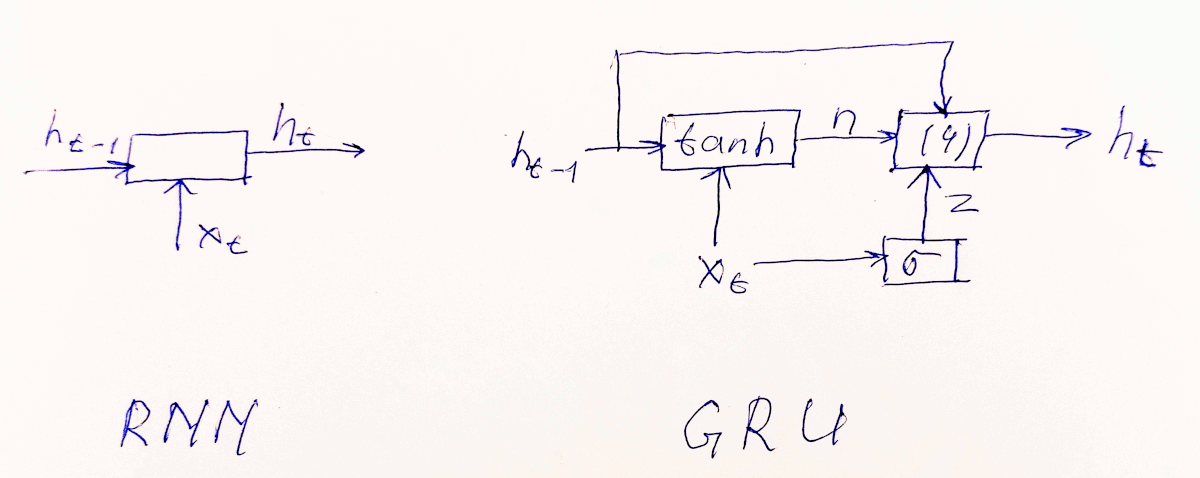

Here box with (4) is the reference to the formula (4).

# GRU Cell

And here is the Python code:
```python
class GRUCell(Module):
    ...
    def forward(self, X, h=None):
        bs, _ = X.shape
        shape = bs, self.hidden_size
        h = h or init.zeros(*shape, device=self.device, dtype=self.dtype)

        X_new = X @ self.W_ih
        h_new = h @ self.W_hh
        if self.bias:
            add_dim = 1, 3 * self.hidden_size
            shape = bs, 3 * self.hidden_size
            X_new += self.bias_ih.reshape(add_dim).broadcast_to(shape)
            h_new += self.bias_hh.reshape(add_dim).broadcast_to(shape)

        xr, xz, xn = ops.split(X_new.reshape((bs, 3, self.hidden_size)), axis=1)
        hr, hz, hn = ops.split(h_new.reshape((bs, 3, self.hidden_size)), axis=1)

        r = Sigmoid()(hr + xr)  # reset gates
        z = Sigmoid()(hz + xz)  # update gates
        n = Tanh()(r * hn + xn)  # new gates (candidate for replacing h)

        h_out = (1 - z) * n + z * h
        return h_out
```

Now let's test it by comparing it with PyTorch.

In [1]:
import sys
sys.path.append('./python')

import needle as ndl
import numpy as np
import torch

In [2]:
x = ndl.init.randn(1, 20, dtype="float32")
h0 = ndl.init.randn(1, 100, dtype="float32")

Here goes PyTorch implementation:

In [3]:
model_torch = torch.nn.GRUCell(20, 100)
print(model_torch.weight_hh.shape)
print(model_torch.weight_ih.shape)

torch.Size([300, 100])
torch.Size([300, 20])


In [4]:
h_ = model_torch(torch.tensor(x.numpy()), torch.tensor(h0.numpy()))

And now our implementation for Needle:

In [5]:
model_needle = ndl.nn.GRUCell(20, 100)
print(model_needle.W_hh.shape)
print(model_needle.W_ih.shape)

(100, 300)
(20, 300)


In [6]:
model_needle.W_hh = ndl.nn.Parameter(ndl.Tensor(model_torch.weight_hh.detach().numpy().T, requires_grad=True))
model_needle.W_ih = ndl.nn.Parameter(ndl.Tensor(model_torch.weight_ih.detach().numpy().T, requires_grad=True))
model_needle.bias_hh = ndl.nn.Parameter(ndl.Tensor(model_torch.bias_hh.detach().numpy(), requires_grad=True))
model_needle.bias_ih = ndl.nn.Parameter(ndl.Tensor(model_torch.bias_ih.detach().numpy(), requires_grad=True))

h = model_needle.forward(x, h0)

The moment of truth - let's compare the results.

In [7]:
np.linalg.norm(h.detach().numpy() - h_.detach().numpy())

4.7480282e-07

The difference between the reference solution and ours is within numerical precision.

In [8]:
%%timeit
h_ = model_torch(torch.tensor(x.numpy()), torch.tensor(h0.numpy()))

220 µs ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
h = model_needle.forward(x, h0)

1.32 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# GRU

Now let's test full GRU Class. Its code is the same as for RNN Class. So for the sake of brevity, we do not provide it here.

In [10]:
X = ndl.init.randn(50, 128, 20, dtype="float32")
h0 = ndl.init.randn(1, 128, 100, dtype="float32")

PyTorch implementation:

In [11]:
model_torch = torch.nn.GRU(20, 100, num_layers=1)
print(model_torch.weight_hh_l0.shape)
print(model_torch.weight_ih_l0.shape)

torch.Size([300, 100])
torch.Size([300, 20])


In [12]:
out_, h_ = model_torch(torch.tensor(X.numpy()), torch.tensor(h0.numpy()))

Needle implementation:

In [13]:
model_needle = ndl.nn.GRU(20, 100, num_layers=1)
print(model_needle.gru_cells[0].W_hh.shape)
print(model_needle.gru_cells[0].W_ih.shape)

(100, 300)
(20, 300)


In [14]:
model_needle.gru_cells[0].W_hh = ndl.nn.Parameter(ndl.Tensor(
    model_torch.weight_hh_l0.detach().numpy().T,
    requires_grad=True
))
model_needle.gru_cells[0].W_ih = ndl.nn.Parameter(ndl.Tensor(
    model_torch.weight_ih_l0.detach().numpy().T,
    requires_grad=True
))
model_needle.gru_cells[0].bias_hh = ndl.nn.Parameter(ndl.Tensor(
    model_torch.bias_hh_l0.detach().numpy(),
    requires_grad=True
))
model_needle.gru_cells[0].bias_ih = ndl.nn.Parameter(ndl.Tensor(
    model_torch.bias_ih_l0.detach().numpy(),
    requires_grad=True
))

out, h = model_needle.forward(X, h0)

Let's compare the results:

In [15]:
print(np.linalg.norm(h.detach().numpy() - h_.detach().numpy()))
print(np.linalg.norm(out.detach().numpy() - out_.detach().numpy()))

1.891075e-06
1.4393566e-05


And again the difference is within numerical precision.

In [16]:
%%timeit
out_, h_ = model_torch(torch.tensor(X.numpy()), torch.tensor(h0.numpy()))

31.9 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%timeit
out, h = model_needle.forward(X, h0)

156 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
